## Librerias

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.special import softmax

## Cargar csv

In [52]:
#Ingestamos las reviews de los hoteles
reviews = pd.read_csv('reviews_hoteles.csv',index_col=0)
reviews.reset_index(drop=True,inplace=True)

## Preprocesamiento:

### Nulos

In [54]:
#Ignoramos las filas que tienen nulos
df = reviews[reviews.text.isnull() == False]

### Duplicados

In [55]:
#Ignoramos las filas duplicadas
df = df[df['text'].duplicated() == False]

In [57]:
df.reset_index(drop=True,inplace=True)

## Visualizaciones previas

Text(0.5, 1.0, 'Conteo de reviews por rating')

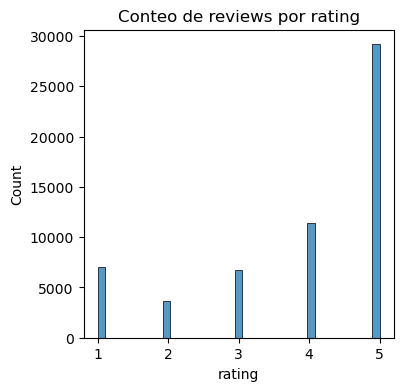

In [59]:
#Gráfico de rating
plt.figure(figsize=(4,4))
sns.histplot(data=df,x="rating")
plt.title('Conteo de reviews por rating')

In [60]:
#Nueva columna de la cantidad de caracteres que hay en un texto
df["long_text"] = df["text"].apply(len)

Text(0.5, 1.0, 'Histograma cantidad de carracteres')

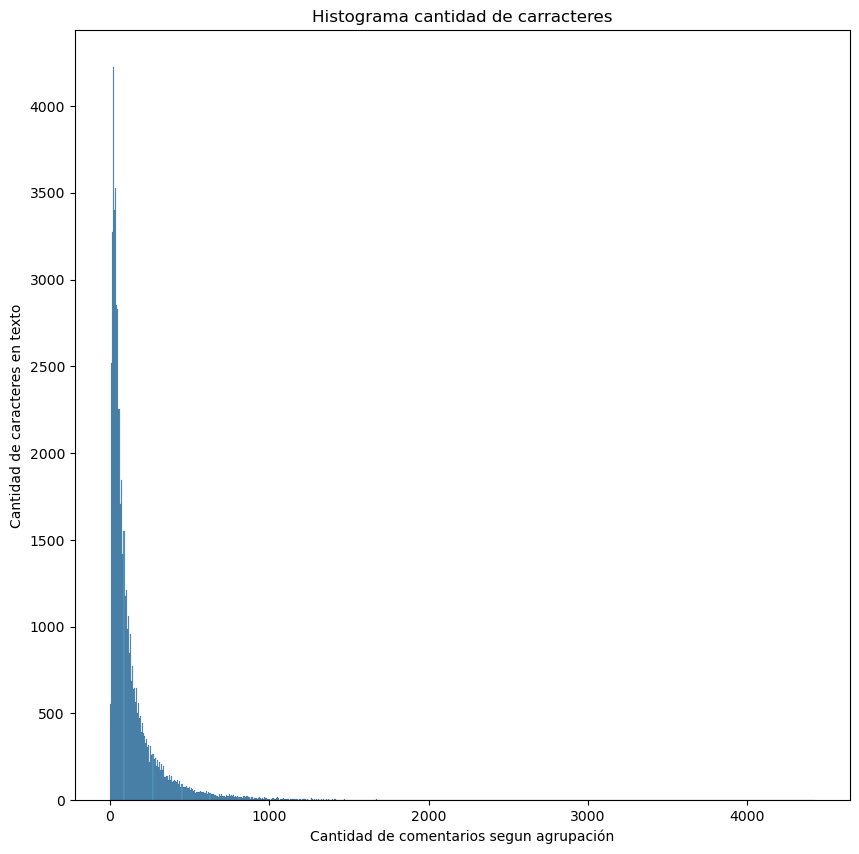

In [61]:
#Cantidad de caracteres según 
plt.figure(figsize=(10,10))
sns.histplot(data=df,x="long_text")
plt.ylabel('Cantidad de caracteres en texto')
plt.xlabel('Cantidad de comentarios segun agrupación')
plt.title('Histograma cantidad de carracteres')

## Preparación de datos para WordCloud

In [62]:
def message_cleaning(message):
    '''La función seleciona hace 3 cosas: Poner la cadena en miníscula, eliminar signos de puntuación y quitar stopwords'''
    message = message.lower()
    test_punc_removed = [char for char in message if char not in string.punctuation]
    test_punc_removed_join = "".join(test_punc_removed)
    stop_words = set(stopwords.words('english') + ['cant','im','u','werent','couldnt','dont','didnt','wasnt','us','want','ive','youre']+['google','translated'])
    test_punc_removed_join_clean = [palabra for palabra in test_punc_removed_join.split() if palabra not in stop_words]
    join = " ".join(test_punc_removed_join_clean)
    return join

In [63]:
#Creamos una columna aplicando la función
df['keywords'] = df["text"].apply(lambda x: message_cleaning(x))

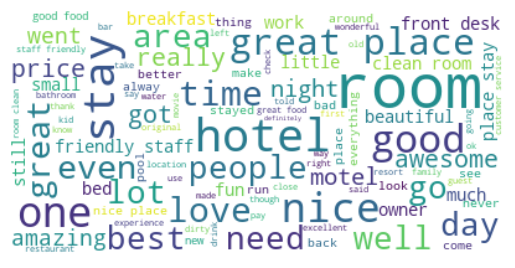

In [64]:
#Se crea el wordcloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(df.keywords))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [65]:
#Se filtran por rating: malo , neutro y bueno
df_bad = df[df.rating.isin([1,2])] 
df_neu = df[df.rating == 3] 
df_great = df[df.rating.isin([4,5])] 

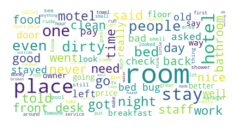

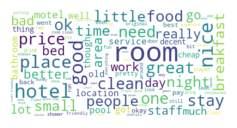

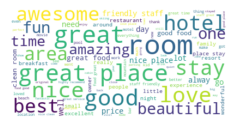

In [66]:
#Se crea un wordcloud usando el filtrado de malo, neutro y bueno
plt.subplot(3,1,1)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(df_bad.keywords))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

plt.subplot(3,1,2)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(df_neu.keywords))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

plt.subplot(3,1,3)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(df_great.keywords))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Modelo de Analísis de sentimiento

### 1. Módelo: Vader 

In [67]:
#Función para aplicar el primer analísis de sentimiento
analyser = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

In [68]:
#Se crean listas vacias para colocar las categorias que nos da el analisis de sentimiento: negative, neutro, positive y compound 
neg=[]
neu=[]
pos=[]
comp=[]
for review in df.text:
    scores=sentiment_analyzer_scores(str(review))
    neg.append(scores['neg'])
    pos.append(scores['pos'])
    neu.append(scores['neu'])
    comp.append(scores['compound'])

In [69]:
#Se crean columnas con las categorias de analisis de sentimiento
df['s_pos']=pos
df['s_neu']=neu
df['s_neg']=neg
df['s_comp']=comp

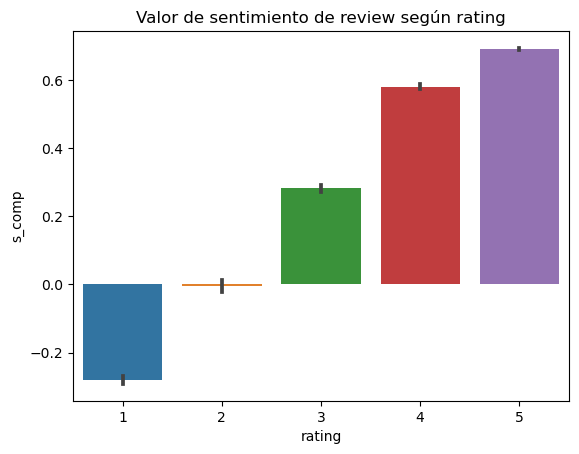

In [70]:
ax = sns.barplot(data = df , x='rating', y='s_comp')
ax.set_title('Valor de sentimiento de review según rating')
plt.show()

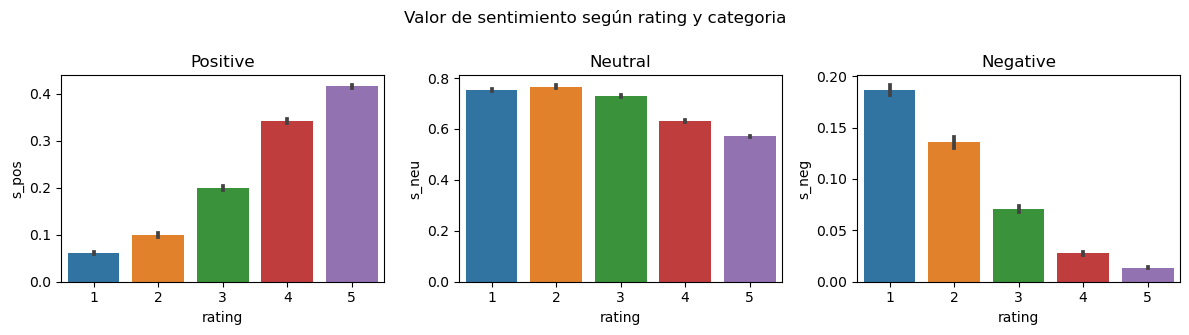

In [71]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=df, x='rating', y='s_pos', ax=axs[0])
sns.barplot(data=df, x='rating', y='s_neu', ax=axs[1])
sns.barplot(data=df, x='rating', y='s_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.suptitle('Valor de sentimiento según rating y categoria',y = 1.1)
plt.show()

### 2. Módelo: Roberta

In [72]:
#pip install transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
#pip install tqdm
from tqdm.notebook import tqdm
#pip install torch

In [73]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer_roberta = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [74]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer_roberta(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [75]:
df['text_350'] = df.text.apply(lambda x: x[:350])

In [77]:
#Este codigo realizara el proceso de sentimiento de analisis y demora 164 min con 8GB de Ram
'''
neg_rob=[]
neu_rob=[]
pos_rob=[]
for review in df.text_350:
    try:    
        scores = polarity_scores_roberta(str(review))
        neg_rob.append(scores['roberta_neg'])
        neu_rob.append(scores['roberta_neu'])
        pos_rob.append(scores['roberta_pos'])
    except RuntimeError:
        print(review)

df['r_pos']= pos_rob
df['r_neu']= neu_rob
df['r_neg']= neg_rob

df.to_csv('reviews_sentiment_roberta.csv', index=False)

'''

"\nneg_rob=[]\nneu_rob=[]\npos_rob=[]\nfor review in df.text_350:\n    try:    \n        scores = polarity_scores_roberta(str(review))\n        neg_rob.append(scores['roberta_neg'])\n        neu_rob.append(scores['roberta_neu'])\n        pos_rob.append(scores['roberta_pos'])\n    except RuntimeError:\n        print(review)\n\ndf['r_pos']= pos_rob\ndf['r_neu']= neu_rob\ndf['r_neg']= neg_rob\n\ndf.to_csv('reviews_sentiment_roberta.csv', index=False)\n\n"

In [105]:
reviews_roberta = pd.read_csv('./Dataset_models/reviews_sentiment_roberta.csv',index_col=0)

In [106]:
reviews_roberta

,user_id,name,time,rating,text,pics,resp,gmap_id,url_origen,long_text,keywords,s_pos,s_neu,s_neg,s_comp,sentiment,word_count,r_neu,r_pos,r_neg
Unnamed: 0,,,,,,,,,,,,,,,,,,,,
1063,1.149921e+20,Cherena Dukes,1574336225144,4,Nice homes in fairly new subdivisions.,NaN,NaN,0x88892dc32d67742d:0x91dc8f0e85b37f5e,d:/Henry/Proyecto Final/Data/Reviews/review-Al...,38,nice homes fairly new subdivisions,0.359,0.641,0.000,0.4215,0,6,0.071708,0.924495,0.003797
1064,1.096825e+20,Lee Morrison,1543167503668,2,Roads are terrible. Neighbors park in yards. ...,NaN,NaN,0x88892dc32d67742d:0x91dc8f0e85b37f5e,d:/Henry/Proyecto Final/Data/Reviews/review-Al...,81,roads terrible neighbors park yards certain te...,0.130,0.679,0.191,-0.2500,0,13,0.044351,0.003641,0.952007
4637,1.126652e+20,Charlie Cline,1454821094934,4,Good location. Nice staff. Clean. Breakfast ar...,NaN,NaN,0x88890491e9416625:0x2f85307a06ddb16,d:/Henry/Proyecto Final/Data/Reviews/review-Al...,151,good location nice staff clean breakfast area ...,0.331,0.567,0.102,0.8442,1,26,0.076029,0.913552,0.010419
4638,1.086380e+20,Jennifer Passmore,1491966256419,5,Super clean very friendly,NaN,NaN,0x88890491e9416625:0x2f85307a06ddb16,d:/Henry/Proyecto Final/Data/Reviews/review-Al...,25,super clean friendly,0.910,0.090,0.000,0.8777,1,4,0.034817,0.962573,0.002611
4639,1.090791e+20,TheBeckyboo926,1476494074021,5,Amazing! We had a conference room and it was a...,NaN,NaN,0x88890491e9416625:0x2f85307a06ddb16,d:/Henry/Proyecto Final/Data/Reviews/review-Al...,53,amazing conference room awesome,0.515,0.485,0.000,0.8585,1,10,0.006783,0.991632,0.001585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64646,1.111824e+20,Matthew Kohl,1559027870064,5,This place is fine.,NaN,NaN,0x87517905377a560d:0xd221d4bf4a6fda4a,d:/Henry/Proyecto Final/Data/Reviews/review-Wy...,19,place fine,0.375,0.625,0.000,0.2023,0,4,0.109980,0.881135,0.008885
64647,1.057380e+20,Fred Rosa,1532891728458,2,Price is Right. My room didn't look like the ...,NaN,NaN,0x87517905377a560d:0xd221d4bf4a6fda4a,d:/Henry/Proyecto Final/Data/Reviews/review-Wy...,53,price right room look like photos,0.000,0.789,0.211,-0.3404,0,10,0.376113,0.076263,0.547624
64648,1.138017e+20,Robin Reed,1559863253396,1,Nasty dirty place,NaN,NaN,0x87517905377a560d:0xd221d4bf4a6fda4a,d:/Henry/Proyecto Final/Data/Reviews/review-Wy...,17,nasty dirty place,0.000,0.133,0.867,-0.7579,0,3,0.049413,0.007150,0.943437


### 3. Módelo: Julien

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer_julien = AutoTokenizer.from_pretrained("juliensimon/reviews-sentiment-analysis")

model_julien = AutoModelForSequenceClassification.from_pretrained("juliensimon/reviews-sentiment-analysis")

In [ ]:
def polarity_julien(sentence):
    encoded_text = tokenizer_julien(sentence, return_tensors = 'pt')
    output = model_julien(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
    'julien_neg' : scores[0],
    'julien_pos' : scores[1]}
    return scores_dict

In [ ]:
'''neg_jul=[]
pos_jul=[]
for review in df.text_350:
    try:    
        scores = polarity_julien(str(review))
        neg_jul.append(scores['julien_neg'])
        pos_jul.append(scores['julien_pos'])
    except RuntimeError:
        print(review)

df['j_pos']= pos_jul
df['j_neg']= neg_jul'''

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=df, x='rating', y='j_pos', ax=axs[0])
sns.barplot(data=df, x='rating', y='j_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[2].set_title('Negative')
plt.tight_layout()
plt.suptitle('Valor de sentimiento según rating y categoria',y = 1.1)
plt.show()

### 4. Módelo: Distilbert

In [79]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer_distilbert = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

model_distilbert = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

In [80]:
def polarity_distilbert(sentence):
    encoded_text = tokenizer_distilbert(sentence, return_tensors = 'pt')
    output = model_distilbert(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
    'distilbert_neg' : scores[0],
    'distilbert_pos' : scores[1]}
    return scores_dict

In [88]:
'''
neg_dis=[]
pos_dis=[]
for review in df.text_350:
    try:    
        scores = polarity_distilbert(str(review))
        neg_dis.append(scores['distilbert_neg'])
        pos_dis.append(scores['distilbert_pos'])
    except RuntimeError:
        print("error")
'''

In [89]:
df['d_pos']= pos_dis
df['d_neg']= neg_dis

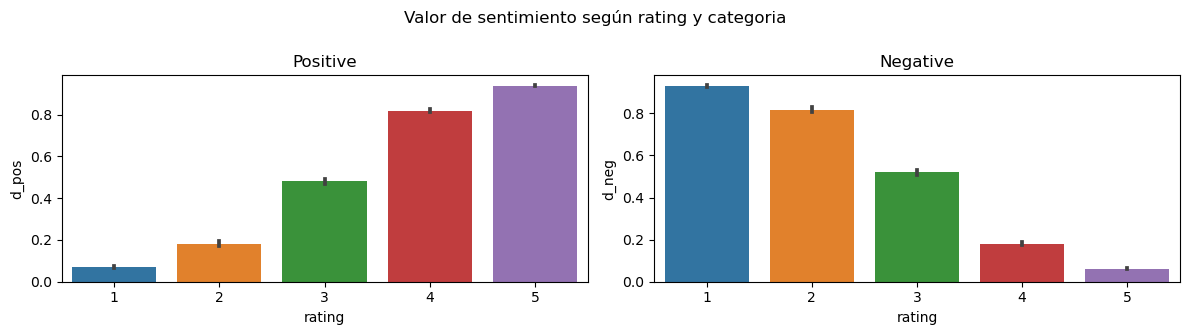

In [91]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
sns.barplot(data=df, x='rating', y='d_pos', ax=axs[0])
sns.barplot(data=df, x='rating', y='d_neg', ax=axs[1])
axs[0].set_title('Positive')
axs[1].set_title('Negative')
plt.tight_layout()
plt.suptitle('Valor de sentimiento según rating y categoria',y = 1.1)
plt.show()

In [92]:
df.to_csv('./Dataset_models/reviews_sentiment_distilbert.csv', index=False)

### 5. Módelo: sbc

In [93]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer_sbcBI = AutoTokenizer.from_pretrained("sbcBI/sentiment_analysis_model")

model_sbcBI = AutoModelForSequenceClassification.from_pretrained("sbcBI/sentiment_analysis_model")

In [99]:
def polarity_sbcBI(sentence):
    encoded_text = tokenizer_sbcBI(sentence, return_tensors = 'pt')
    output = model_sbcBI(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores
    scores_dict = {
    'sbcBI_neg' : scores[0],
    'sbcBI_neu' : scores[1],
    'sbcBI_pos' : scores[2]}
    return scores_dict

In [102]:
'''
neg_sbc=[]
neu_sbc=[]
pos_sbc=[]
for review in df.text_350:
    try:    
        scores = polarity_sbcBI(str(review))
        neg_sbc.append(scores['sbcBI_neg'])
        neu_sbc.append(scores['sbcBI_neu'])
        pos_sbc.append(scores['sbcBI_pos'])
    except RuntimeError:
        print(review)

df['sb_pos']= pos_sbc
df['sb_neu']= neu_sbc
df['sb_neg']= neg_sbc

df.to_csv('./Dataset_models/reviews_sentiment_sbcBI.csv', index=False)
'''

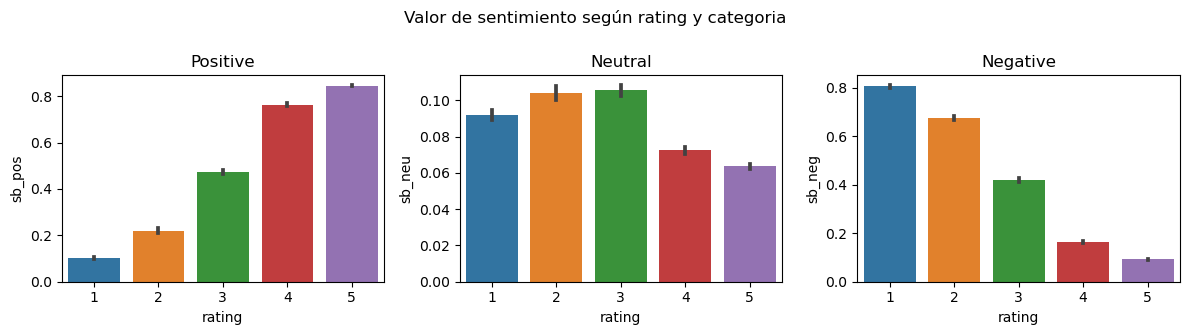

In [103]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=df, x='rating', y='sb_pos', ax=axs[0])
sns.barplot(data=df, x='rating', y='sb_neu', ax=axs[1])
sns.barplot(data=df, x='rating', y='sb_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.suptitle('Valor de sentimiento según rating y categoria',y = 1.1)
plt.show()